In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
data = np.load("non-text-feature.npz")

In [4]:
list(data.keys())

['indices_train',
 'indices_val',
 'indices_test',
 'userID',
 'userID_onehot',
 'itemID',
 'itemID_onehot',
 'verified',
 'review_length',
 'rating',
 'days',
 'weekdays',
 'month',
 'vote']

In [5]:
userID=data['userID']
itemID=data['itemID']

num_user = np.max(userID)+1
num_item = np.max(itemID)+1

In [6]:
import matplotlib.pyplot as plt
def plot(log_loss, log_val_loss, test_loss, title=''):
    plt.figure(figsize=(10, 6))
    epochs = len(log_loss)
    # Plot training and validation loss
    plt.plot(range(epochs), log_loss, label='Training Loss (MSE + reg)')
    plt.plot(range(epochs), log_val_loss, label='Validation Loss (MSE)')

    # Add a horizontal line for test loss
    # Add a horizontal line for test loss
    test_loss_label = f'Test Loss (MSE): {test_loss:.4f}'  # Format with 4 decimal places
    plt.axhline(y=test_loss, color='r', linestyle='--', label=test_loss_label)

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()

In [7]:
has_vote = data['vote']>0

userID=data['userID'][has_vote]
itemID=data['itemID'][has_vote]
vote=np.log10(data['vote'][has_vote])

from sklearn.model_selection import train_test_split
indices = np.arange(len(vote))
indices_train, indices_test = train_test_split(indices, test_size=0.1, random_state=42)
indices_train, indices_val = train_test_split(indices_train, test_size=0.1/0.9, random_state=42)

In [8]:
class bias_model(nn.Module):
    def __init__(self, num_user, num_item, lambda_beta=0.01):
        super(bias_model,  self).__init__()
        self.lambda_beta = torch.scalar_tensor(lambda_beta, device=device)

        # init parameters
        self.alpha = nn.Parameter(torch.randn(1))
        self.beta_user = nn.Parameter(torch.randn(num_user))
        self.beta_item = nn.Parameter(torch.randn(num_item))

        self.to(device)

    def forward(self, userID,  gameID):
        return self.alpha + self.beta_user[userID] + self.beta_item[gameID]
    
    def fit(self, train, val,  lr = 0.001,  num_epochs=3000, patience = 5):
        userID_train = torch.tensor(train[0], device=device)
        itemID_train = torch.tensor(train[1], device=device)
        y_train  = torch.tensor(train[2], device=device, dtype=torch.float)
        userID_val = torch.tensor(val[0], device=device)
        itemID_val = torch.tensor(val[1], device=device)
        y_val  = torch.tensor(val[2], device=device, dtype=torch.float)

        # early stop
        best_val_loss = float('inf')
        epochs_no_improve = 0

        # log
        self.log_loss = []
        self.log_val_loss = []

        # train prep
        optimizer = optim.Adam(self.parameters(),  lr=lr)
        criterion = nn.MSELoss()

        # train loop
        bar = tqdm(range(num_epochs))
        for epoch in bar:
            optimizer.zero_grad()
            predictions = self.forward(userID_train,  itemID_train)
            # Compute loss
            loss = criterion(predictions,  y_train)
            loss +=  self.lambda_beta*(self.beta_user.norm(2) + self.beta_item.norm(2))
            self.log_loss.append(loss.item())
            # backworks
            loss.backward()
            optimizer.step()
            # Early stopping check
            with torch.no_grad():
                val_preds = self.forward(userID_val, itemID_val) # ignore cold start
                val_loss = criterion(val_preds,  y_val)
                self.log_val_loss.append(val_loss.item())
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs')
                    break
            bar.set_postfix({"Epoch":epoch,  "loss": loss.item(),  "val_Loss": val_loss.item()})
        
        return best_val_loss

In [9]:
best_b_model = None
best_lambda = None
best_val_loss = float("inf")
for l_beta in [0.001]:
    b_model = bias_model(num_user, num_item, lambda_beta=l_beta)
    val_loss = b_model.fit(
        [userID[indices_train], itemID[indices_train], vote[indices_train]], 
        [userID[indices_val], itemID[indices_val], vote[indices_val]],
        lr =0.05, num_epochs=1000
    ).item()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_b_model = b_model
        best_lambda = l_beta
print(best_lambda)

 14%|█▍        | 145/1000 [00:00<00:02, 315.84it/s, Epoch=144, loss=0.109, val_Loss=0.15]


Early stopping triggered after 146 epochs
0.001


0.1477068172428734


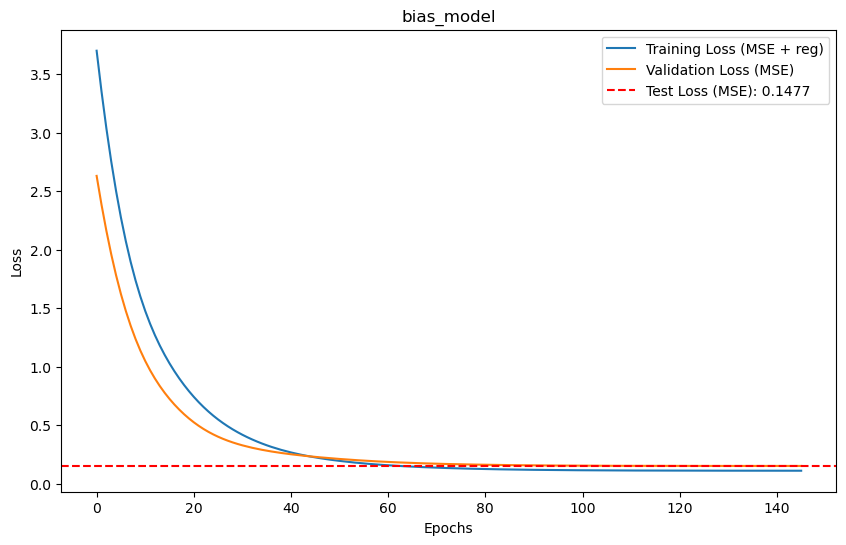

In [10]:
prediction_test = best_b_model(userID[indices_test], itemID[indices_test]).cpu().detach().numpy()
test_loss = mean_squared_error(vote[indices_test], prediction_test)
print(test_loss)
plot(best_b_model.log_loss, best_b_model.log_val_loss, test_loss, "bias_model")

In [11]:
class latent_model(nn.Module):
    def __init__(self, num_user, num_item, latent_num = 1, lambda_beta=0.01, lambda_gamma=0.001):
        super(latent_model,  self).__init__()
        self.lambda_beta = torch.scalar_tensor(lambda_beta, device=device)
        self.lambda_gamma= torch.scalar_tensor(lambda_gamma, device=device)

        # init parameters
        self.alpha = nn.Parameter(torch.randn(1))
        self.beta_user = nn.Parameter(torch.randn(num_user))
        self.beta_item = nn.Parameter(torch.randn(num_item))
        self.gamma_user = nn.Parameter(torch.randn(num_user, latent_num))
        self.gamma_item = nn.Parameter(torch.randn(num_item, latent_num))

        self.to(device)

    def forward(self, userID,  itemID):
        return self.alpha + self.beta_user[userID] + self.beta_item[itemID] + \
            (self.gamma_user[userID] * self.gamma_item[itemID]).sum(dim=1)
    
    def fit(self, train, val,  lr = 0.001,  num_epochs=3000, patience = 5):
        userID_train = torch.tensor(train[0], device=device)
        itemID_train = torch.tensor(train[1], device=device)
        y_train  = torch.tensor(train[2], device=device, dtype=torch.float)
        userID_val = torch.tensor(val[0], device=device)
        itemID_val = torch.tensor(val[1], device=device)
        y_val  = torch.tensor(val[2], device=device, dtype=torch.float)

        # early stop
        best_val_loss = float('inf')
        epochs_no_improve = 0

        # log
        self.log_loss = []
        self.log_val_loss = []

        # train prep
        optimizer = optim.Adam(self.parameters(),  lr=lr)
        criterion = nn.MSELoss()

        # train loop
        bar = tqdm(range(num_epochs))
        for epoch in bar:
            optimizer.zero_grad()
            predictions = self.forward(userID_train,  itemID_train)
            # Compute loss
            loss = criterion(predictions,  y_train)
            loss += self.lambda_beta*(self.beta_user.norm(2) + self.beta_item.norm(2))
            loss += self.lambda_gamma*(self.gamma_item.norm(2) + self.gamma_user.norm(2)) 
            self.log_loss.append(loss.item())
            # backworks
            loss.backward()
            optimizer.step()
            # Early stopping check
            with torch.no_grad():
                val_preds = self.forward(userID_val, itemID_val) # ignore cold start
                val_loss = criterion(val_preds,  y_val)
                self.log_val_loss.append(val_loss.item())
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs')
                    break
            bar.set_postfix({"Epoch":epoch,  "loss": loss.item(),  "val_Loss": val_loss.item()})
        
        return best_val_loss

In [12]:
best_l_model = None
best_lambda = None
best_val_loss = float("inf")
for l_beta in [0.001]:
    for l_gamma in [0.001]:
        l_model = latent_model(num_user, num_item, lambda_beta=l_beta, lambda_gamma=l_gamma)
        val_loss = l_model.fit(
            [userID[indices_train], itemID[indices_train], vote[indices_train]], 
            [userID[indices_val], itemID[indices_val], vote[indices_val]],
            lr =0.05, num_epochs=1000
        ).item()
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_l_model = l_model
            best_lambda = (l_beta, l_gamma)
print(best_lambda)

 24%|██▍       | 239/1000 [00:00<00:01, 470.37it/s, Epoch=238, loss=0.113, val_Loss=0.15] 

Early stopping triggered after 240 epochs
(0.001, 0.001)


0.14764330761208863


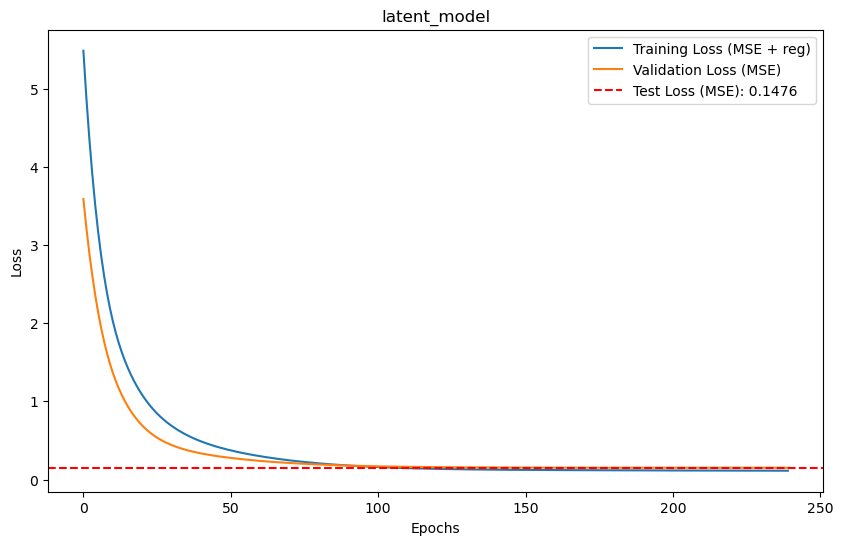

In [13]:
prediction_test = best_l_model(userID[indices_test], itemID[indices_test]).cpu().detach().numpy()
test_loss = mean_squared_error(vote[indices_test], prediction_test)
print(test_loss)
plot(best_l_model.log_loss, best_l_model.log_val_loss, test_loss, "latent_model")

In [14]:
# has_vote = data['vote']>0

# userID = data['userID'][has_vote]
# itemID = data['itemID'][has_vote]
# vote   = np.log10(data['vote'][has_vote])

day   = data['days'][has_vote]
weekday = data['weekdays'][has_vote]
month  =  data['month'][has_vote]

from sklearn.model_selection import train_test_split
indices = np.arange(len(vote))
indices_train, indices_test = train_test_split(indices, test_size=0.1, random_state=42)
indices_train, indices_val = train_test_split(indices_train, test_size=0.1/0.9, random_state=42)

In [15]:
NUM_DAY_BIN = 50
def convert_to_bin_indices(array, num_bins):
    if num_bins < 2:
        raise ValueError("Number of bins must be at least 2.")

    # Calculate quantiles
    quantiles = np.quantile(array, np.linspace(0, 1, num_bins + 1))

    # Assign each element to a bin
    bin_indices = np.digitize(array, quantiles) - 1

    # Ensure the last bin is included
    bin_indices[bin_indices == num_bins] = num_bins - 1

    return bin_indices
day_bin = convert_to_bin_indices(day, NUM_DAY_BIN)

In [16]:
class temporal_bias_model(nn.Module):
    def __init__(self, num_user, num_item, num_day_bins, lambda_beta=0.01):
        super(temporal_bias_model,  self).__init__()
        self.lambda_beta = torch.scalar_tensor(lambda_beta, device=device)
        
        NUM_WEEKDAY = 7
        NUM_MONTH = 12

        # init parameters
        self.alpha = nn.Parameter(torch.randn(1))
        self.beta_item_base = nn.Parameter(torch.randn(num_item))
        self.beta_item_days = nn.Parameter(torch.randn(num_item, num_day_bins))
        self.beta_item_weekdays = nn.Parameter(torch.randn(num_item, NUM_WEEKDAY))
        self.beta_item_months = nn.Parameter(torch.randn(num_item, NUM_MONTH))

        self.beta_user_base = nn.Parameter(torch.randn(num_user))
        self.dev_user_a = nn.Parameter(torch.randn(1))
        self.dev_user_b = nn.Parameter(torch.randn(1))

        self.to(device)

    def forward(self, userID, itemID, day, day_bin, weekday, month):
        # Compute beta_i(t)
        beta_i = self.beta_item_base[itemID] + self.beta_item_days[itemID, day_bin] +\
                 self.beta_item_weekdays[itemID, weekday] + self.beta_item_months[itemID, month]

        # Compute beta_u(t)
        beta_u = self.beta_user_base[userID] + self.dev_user_a * torch.exp(-self.dev_user_b * day)
        return self.alpha + beta_u + beta_i
    
    def fit(self, train, val,  lr = 0.001, num_epochs=3000, patience = 5):
        userID_train = torch.tensor(train[0], device=device)
        itemID_train = torch.tensor(train[1], device=device)
        day_train    = torch.tensor(train[2], device=device)
        day_bin_train= torch.tensor(train[3], device=device)
        weekday_train= torch.tensor(train[4], device=device)
        month_train  = torch.tensor(train[5], device=device)
        y_train      = torch.tensor(train[6], device=device, dtype=torch.float)

        userID_val = torch.tensor(val[0], device=device)
        itemID_val = torch.tensor(val[1], device=device)
        day_val    = torch.tensor(val[2], device=device)
        day_bin_val= torch.tensor(val[3], device=device)
        weekday_val= torch.tensor(val[4], device=device)
        month_val  = torch.tensor(val[5], device=device)
        y_val      = torch.tensor(val[6], device=device, dtype=torch.float)

        #early stop
        best_val_loss = float('inf')
        epochs_no_improve = 0

        # log
        self.log_loss = []
        self.log_val_loss = []

        # train prep
        optimizer = optim.Adam(self.parameters(),  lr=lr)
        criterion = nn.MSELoss()

        # train loop
        bar = tqdm(range(num_epochs))
        for epoch in bar:
            optimizer.zero_grad()

            predictions = self.forward(userID_train, itemID_train, day_train, day_bin_train, weekday_train, month_train)
            # Compute loss
            loss = criterion(predictions,  y_train)
            loss +=  self.lambda_beta*(self.beta_item_base.norm(2) + self.beta_user_base.norm(2) +\
                                       self.beta_item_days.norm(2) + self.beta_item_weekdays.norm(2) + self.beta_item_months.norm(2))
            self.log_loss.append(loss.item())
            # backworks
            loss.backward()
            optimizer.step()
            
            # Early stopping check
            with torch.no_grad():
                val_preds = self.forward(userID_val, itemID_val, day_val, day_bin_val, weekday_val, month_val) # ignore cold start
                val_loss = criterion(val_preds,  y_val)
                self.log_val_loss.append(val_loss.item())
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs')
                    break
            bar.set_postfix({"Epoch":epoch, "loss": loss.item(), "val_Loss": val_loss.item()})
        
        return best_val_loss

In [17]:
best_tb_model = None
best_lambda = None
best_val_loss = float("inf")
for l_beta in  [0.001]:
    tb_model = temporal_bias_model(num_user, num_item, NUM_DAY_BIN, lambda_beta=l_beta)
    val_loss = tb_model.fit(
        [x[indices_train] for x in [userID, itemID, day, day_bin, weekday, month, vote]], 
        [x[indices_val] for x in [userID, itemID, day, day_bin, weekday, month, vote]], 
        lr =0.05, num_epochs=500, patience=10
    )
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_tb_model = tb_model
        best_lambda = l_beta
print(best_lambda)

  2%|▏         | 9/500 [00:00<00:02, 220.76it/s, Epoch=8, loss=nan, val_Loss=nan]

Early stopping triggered after 10 epochs
None


In [18]:
prediction_test = best_tb_model.forward(*[torch.tensor(x[indices_test], device=device) for x in [userID, itemID, day, day_bin, weekday, month]]).cpu().detach().numpy()
test_loss = mean_squared_error(vote[indices_test], prediction_test)
print(test_loss)
plot(best_tb_model.log_loss, best_tb_model.log_val_loss, test_loss, "temporal_bias_model")

AttributeError: 'NoneType' object has no attribute 'forward'

In [19]:
class temporal_latent_model(nn.Module):
    def __init__(self, num_user, num_item, num_day_bins, latent_num=1, lambda_beta=0.01, lambda_gamma=0.01):
        super(temporal_latent_model,  self).__init__()
        self.lambda_beta = torch.scalar_tensor(lambda_beta, device=device)
        self.lambda_gamma= torch.scalar_tensor(lambda_gamma, device=device)
        
        NUM_WEEKDAY = 7
        NUM_MONTH = 12

        # init parameters
        self.alpha = nn.Parameter(torch.randn(1))
        self.beta_item_base = nn.Parameter(torch.randn(num_item))
        self.beta_item_days = nn.Parameter(torch.randn(num_item, num_day_bins))
        self.beta_item_weekdays = nn.Parameter(torch.randn(num_item, NUM_WEEKDAY))
        self.beta_item_months = nn.Parameter(torch.randn(num_item, NUM_MONTH))

        self.beta_user_base = nn.Parameter(torch.randn(num_user))
        self.dev_user_a = nn.Parameter(torch.randn(1))
        self.dev_user_b = nn.Parameter(torch.randn(1))

        self.gamma_user = nn.Parameter(torch.randn(num_user, latent_num))
        self.gamma_item = nn.Parameter(torch.randn(num_item, latent_num))

        self.to(device)

    def forward(self, userID, itemID, day, day_bin, weekday, month):
        # Compute beta_i(t)
        beta_i = self.beta_item_base[itemID] + self.beta_item_days[itemID, day_bin] +\
                 self.beta_item_weekdays[itemID, weekday] + self.beta_item_months[itemID, month]

        # Compute beta_u(t)
        beta_u = self.beta_user_base[userID] + self.dev_user_a * torch.exp(-self.dev_user_b * day)
        return self.alpha + beta_u + beta_i + (self.gamma_user[userID] * self.gamma_item[itemID]).sum(dim=1)
    
    def fit(self, train, val,  lr = 0.001, num_epochs=3000, patience = 5):
        userID_train = torch.tensor(train[0], device=device)
        itemID_train = torch.tensor(train[1], device=device)
        day_train    = torch.tensor(train[2], device=device)
        day_bin_train= torch.tensor(train[3], device=device)
        weekday_train= torch.tensor(train[4], device=device)
        month_train  = torch.tensor(train[5], device=device)
        y_train      = torch.tensor(train[6], device=device, dtype=torch.float)

        userID_val = torch.tensor(val[0], device=device)
        itemID_val = torch.tensor(val[1], device=device)
        day_val    = torch.tensor(val[2], device=device)
        day_bin_val= torch.tensor(val[3], device=device)
        weekday_val= torch.tensor(val[4], device=device)
        month_val  = torch.tensor(val[5], device=device)
        y_val      = torch.tensor(val[6], device=device, dtype=torch.float)

        #early stop
        best_val_loss = float('inf')
        epochs_no_improve = 0

        # log
        self.log_loss = []
        self.log_val_loss = []

        # train prep
        optimizer = optim.Adam(self.parameters(),  lr=lr)
        criterion = nn.MSELoss()

        # train loop
        bar = tqdm(range(num_epochs))
        for epoch in bar:
            optimizer.zero_grad()

            predictions = self.forward(userID_train, itemID_train, day_train, day_bin_train, weekday_train, month_train)
            # Compute loss
            loss = criterion(predictions,  y_train)
            loss +=  self.lambda_beta*(self.beta_item_base.norm(2) + self.beta_user_base.norm(2) +\
                                       self.beta_item_days.norm(2) + self.beta_item_weekdays.norm(2) + self.beta_item_months.norm(2))
            loss += self.lambda_gamma*(self.gamma_item.norm(2) + self.gamma_user.norm(2))
            self.log_loss.append(loss.item())
            # backworks
            loss.backward()
            optimizer.step()
            
            # Early stopping check
            with torch.no_grad():
                val_preds = self.forward(userID_val, itemID_val, day_val, day_bin_val, weekday_val, month_val) # ignore cold start
                val_loss = criterion(val_preds,  y_val)
                self.log_val_loss.append(val_loss.item())
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs')
                    break
            bar.set_postfix({"Epoch":epoch, "loss": loss.item(), "val_Loss": val_loss.item()})
        
        return best_val_loss

In [ ]:
best_tl_model = None
best_lambda = None
best_val_loss = float("inf")
for l_beta in  [0.001]:
    for l_gamma in [0.03981071705534969]:
        tl_model = temporal_latent_model(num_user, num_item, NUM_DAY_BIN, lambda_beta=l_beta)
        val_loss = tl_model.fit(
            [x[indices_train] for x in [userID, itemID, day, day_bin, weekday, month, vote]], 
            [x[indices_val] for x in [userID, itemID, day, day_bin, weekday, month, vote]], 
            lr =0.05, num_epochs=500, patience=10
        )
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_tl_model = tl_model
            best_lambda = (l_beta, l_gamma)
print(best_lambda)

0.12616110692055538


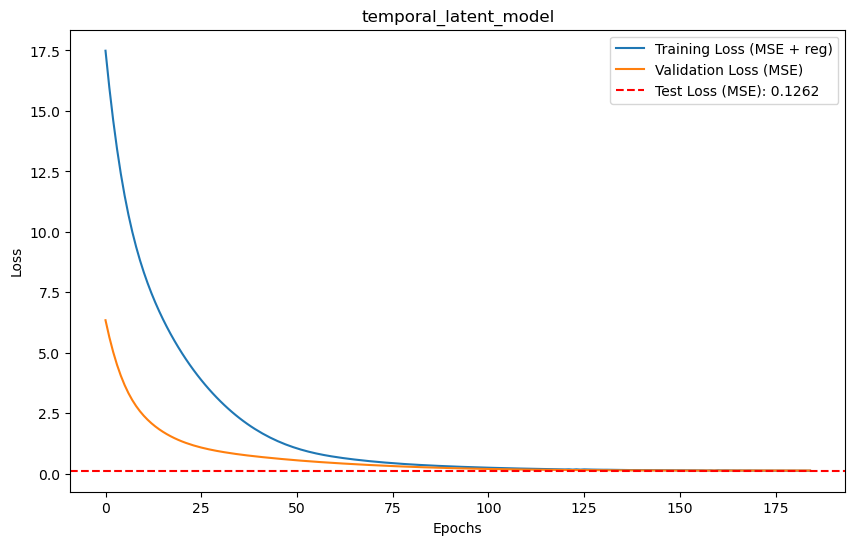

In [ ]:
prediction_test = best_tl_model.forward(*[torch.tensor(x[indices_test], device=device) for x in [userID, itemID, day, day_bin, weekday, month]]).cpu().detach().numpy()
test_loss = mean_squared_error(vote[indices_test], prediction_test)
print(test_loss)
plot(tl_model.log_loss, tl_model.log_val_loss, test_loss, "temporal_latent_model")

In [ ]:
torch.save(best_b_model, "best_b_model.ckpt")
torch.save(best_l_model, "best_l_model.ckpt")
torch.save(best_tb_model, "best_tb_model.ckpt")
torch.save(best_tl_model, "best_tl_model.ckpt")
